In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
import PIL
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

In [19]:
import pandas as pd
age_df = pd.read_csv("C:\\Users\\Daman\\Documents\\Bone Age Prediction\\boneage-training-dataset.csv")

age_df['path'] = age_df['id'].map(lambda x: os.path.join("C:\\Users\\Daman\\Documents\\Bone Age Prediction\\boneage-training-dataset", 
                                                         '{}.png'.format(x)))
age_df['exists'] = age_df['path'].map(os.path.exists)
print(age_df['exists'].sum(), 'images found of', age_df.shape[0], 'total')
age_df['gender'] = age_df['male'].map(lambda x: 'male' if x else 'female')
boneage_mean = age_df['boneage'].mean()
boneage_div = 2*age_df['boneage'].std()
# we don't want normalization for now
boneage_mean = 0
boneage_div = 1.0
age_df['boneage_zscore'] = age_df['boneage'].map(lambda x: (x-boneage_mean)/boneage_div)
age_df.dropna(inplace = True)
age_df.sample(3)

12611 images found of 12611 total


,id,boneage,male,path,exists,gender,boneage_zscore
3574,5536,156,True,C:\Users\Daman\Documents\Bone Age Prediction\b...,True,male,156.0
1476,3020,15,False,C:\Users\Daman\Documents\Bone Age Prediction\b...,True,female,15.0
1179,2686,144,False,C:\Users\Daman\Documents\Bone Age Prediction\b...,True,female,144.0


In [20]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
IMG_SIZE = (384, 384) # slightly smaller than vgg16 normally expects
core_idg = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range=0.25,
                             preprocessing_function = preprocess_input)

In [21]:
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(age_df, 
                                   test_size = 0.25, 
                                   random_state = 2018)
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 9458 validation 3153


New Data Size: 11000 Old Size: 9458


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000214F5E45A58>,
      dtype=object)

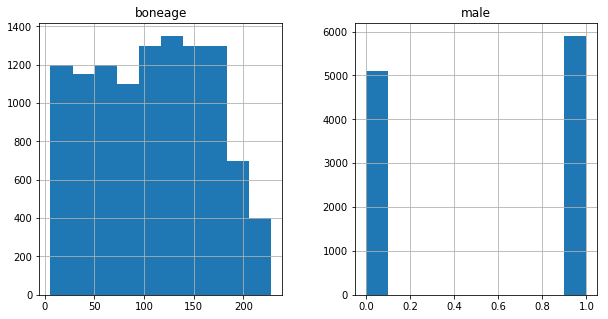

In [22]:
train_df = raw_train_df.groupby(['boneage', 'male']).apply(lambda x: x.sample(50, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['boneage', 'male']].hist(figsize = (10, 5))

In [23]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [29]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 16)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 16) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 16)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 11000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3153 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3153 images


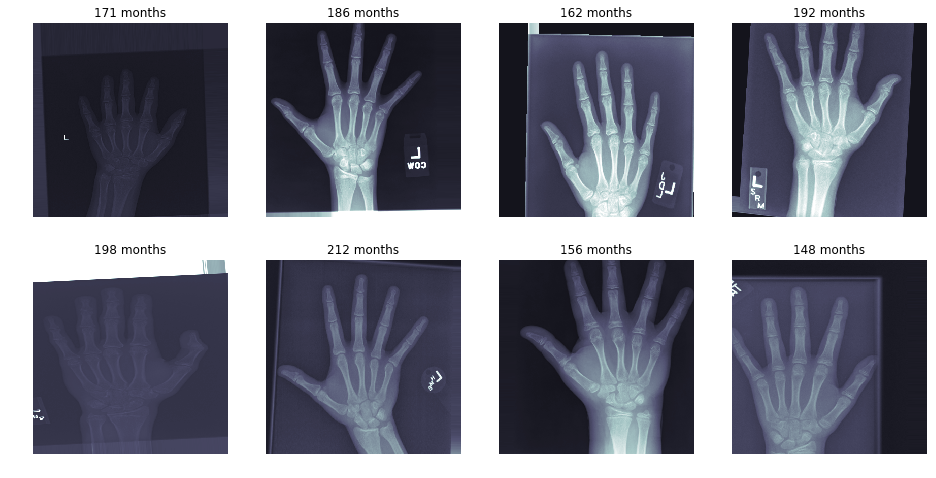

In [30]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -127, vmax = 127)
    c_ax.set_title('%2.0f months' % (c_y*boneage_div+boneage_mean))
    c_ax.axis('off')

In [31]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = VGG16(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = LocallyConnected2D(1, 
                                kernel_size = (1,1), 
                                padding = 'valid', 
                                activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(1024, activation = 'elu')(gap_dr))
out_layer = Dense(1, activation = 'linear')(dr_steps) # linear is what 16bit did
bone_age_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import mean_absolute_error
def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div*in_gt, boneage_div*in_pred)

bone_age_model.compile(optimizer = 'adam', loss = 'mse',
                           metrics = [mae_months])

bone_age_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 12, 12, 512)  14714688    input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 12, 12, 512)  2048        vgg16[1][0]                      
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 12, 12, 64)   32832       batch_normalization_2[0][0]      
__________________________________________________________________________________________________
conv2d_5 (

In [32]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('bone_age')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [33]:
bone_age_model.fit_generator(train_gen, 
                                  validation_data = (test_X, test_Y), 
                                  epochs = 15, 
                                  callbacks = callbacks_list)

Epoch 1/15
688/688 [==============================] - 1008s 1s/step - loss: 1844.4929 - mae_months: 30.0046 - val_loss: 821.2772 - val_mae_months: 22.2852

Epoch 00001: val_loss improved from inf to 821.27722, saving model to bone_age_weights.best.hdf5
Epoch 2/15
688/688 [==============================] - 999s 1s/step - loss: 679.6008 - mae_months: 20.5295 - val_loss: 678.2355 - val_mae_months: 20.6045

Epoch 00002: val_loss improved from 821.27722 to 678.23547, saving model to bone_age_weights.best.hdf5
Epoch 3/15
688/688 [==============================] - 999s 1s/step - loss: 515.0896 - mae_months: 17.6065 - val_loss: 524.1578 - val_mae_months: 17.4529

Epoch 00003: val_loss improved from 678.23547 to 524.15778, saving model to bone_age_weights.best.hdf5
Epoch 4/15
688/688 [==============================] - 999s 1s/step - loss: 426.6465 - mae_months: 15.9646 - val_loss: 770.0686 - val_mae_months: 22.0256

Epoch 00004: val_loss did not improve
Epoch 5/15
688/688 [=====================

In [34]:
bone_age_model.load_weights(weight_path)


In [35]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in bone_age_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

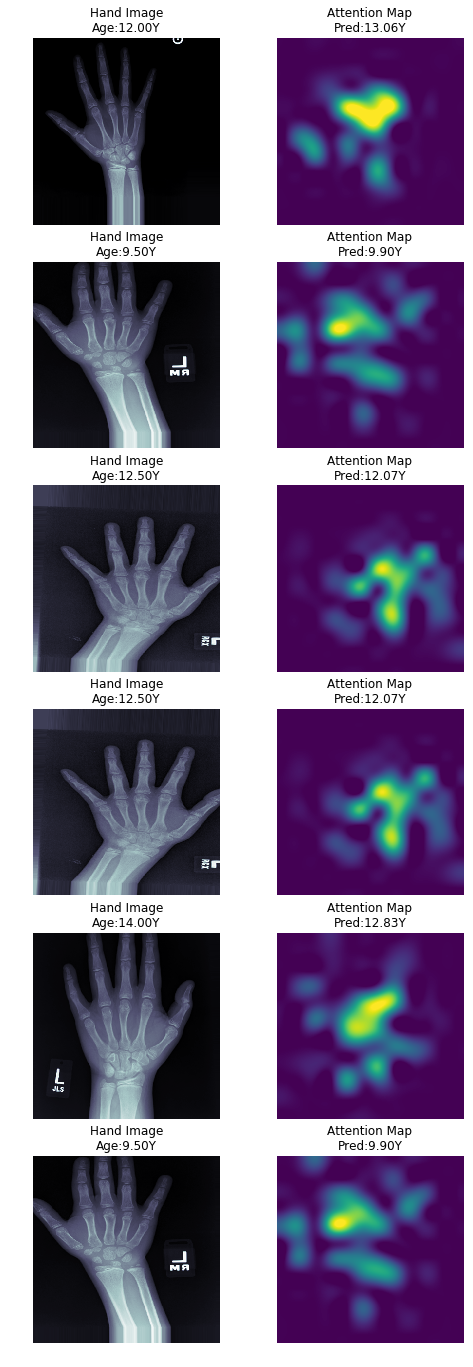

In [36]:
import keras.backend as K
rand_idx = np.random.choice(range(len(test_X)), size = 6)
attn_func = K.function(inputs = [bone_age_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(cur_img[0,:,:,0], cmap = 'bone')
    attn_ax.imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_age = boneage_div*test_Y[c_idx]+boneage_mean
    img_ax.set_title('Hand Image\nAge:%2.2fY' % (real_age/12))
    pred_age = boneage_div*bone_age_model.predict(cur_img)+boneage_mean
    attn_ax.set_title('Attention Map\nPred:%2.2fY' % (pred_age/12))
fig.savefig('attention_map.png', dpi = 300)

In [37]:
pred_Y = boneage_div*bone_age_model.predict(test_X, batch_size = 32, verbose = True)+boneage_mean
test_Y_months = boneage_div*test_Y+boneage_mean

16/16 [==============================] - 1s 91ms/step


In [39]:
pred_Y

array([[156.76807],
       [118.81461],
       [ 91.31373],
       [210.2307 ],
       [176.1643 ],
       [ 51.48221],
       [157.72693],
       [144.81122],
       [124.27635],
       [141.46149],
       [154.41792],
       [147.00533],
       [179.71254],
       [139.29094],
       [149.17725],
       [153.92136]], dtype=float32)

In [40]:
test_Y_months

array([144., 114.,  84., 192., 168.,  60., 156., 150., 162., 132., 144.,
       156., 222., 150., 138., 168.])

In [42]:
sum = 0;
for x, y in zip(pred_Y, test_Y_months):
    sum = sum + x - y
average = sum/len(pred_Y)
average

array([-2.7140665], dtype=float32)